## <div style="text-align: right"> Mayank Pathak </div>
# Project 1 
## CNN approach on CIFAR10 Dataset 

### November 14, 2018

- 1. **Introduction** 
    - 1.1 Importing Necessary libraries
    - 1.2 Defining Hyper-Parameters
- 2. **Data Preparation**
    - 2.1  Load Data
    - 2.2  Show Sample Training Images and Labels
- 3. **Neural Network**
    - 3.1 Function to adjust learning rate
    - 3.2 Class Module to implement for network
    - 3.3 Function to implement training
    - 3.4 Function to implement testing
- 4. **Evaluate Model**
    - 4.1 Plot Accuracy and Loss curves

### 1. Introduction

#### 1.1 Importing necessary libraries:
Libraries used for to create this network:
    1. numpy
    2. matplotlib
    3. torch
    4. sklearn
    5. torch vision
    6. os

In [2]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch import autograd
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.autograd.variable import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

%matplotlib inline

#### 1.2 Defining Hyper-Parameters and other required Parameters
The Hyper-Parameters for this model are:

   1. **batch size:** by playing around with batch sizes from (3 to 128), 10 gives the most optimal result. 
   2. **learning rate:** learning rate 0.01 helps train the network in appropriate time.
   3. **weight decay:** to keep it low, 0.0005 is chosen
   4. **epochs:** by trying different epochs, 20 epochs are used to train. However, after 18 epochs the network             accuracy saturates
   5. **pool size:** for image size of 32x32, pool size of 2 is optimal.
   6. **number of classes:** its 10, the number of output classes.
   7. **optimizer:** Adam optimizer is used because its ability for weight decay and decaying learning rate.

In [3]:
# Parameters
batch_size = 10
learning_rate = 0.01
weight_decay = 0.0005
num_epochs = 20
pool_size = 2
num_classes = 10


### 2. Data Preparation

#### 2.1 Load Data
The input images and labels are loaded using the Dataloader class. Training Data is shuffled everytime it is loaded. 50000 Training images and 10000 testing images<br>

> Number of Input Images: 60,000 <br>
> TrainImages shape: (50000,32,32,3) <br>
> TestImages shape: (10000,32,32,3)

In [4]:
#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#Load the training set
train_set =CIFAR10(root="./data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = Data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)


Files already downloaded and verified


In [5]:
# Define transformations for the test set
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

# Load the test set, note that train is set to False
test_set = CIFAR10(root="./data", train=False, transform=test_transformations, download=True)

# Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### 2.2 Show Sample Data
Code snipet to show 10 images from the dataset<br>

deer   cat   ship   cat   horse   bird   ship   car   plane   dog  


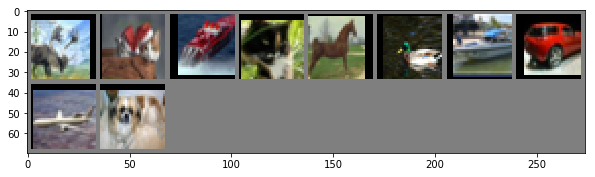

In [5]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace=0.6, hspace=0.4)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s  ' % classes[labels[j]] for j in range(10)))

### 3. Defining Network

The network which I had build for this task is 11 layered network, with 6 Convolution layer, 3 maxpooling layers (kernel size 2), 1 average pooling layer with last layer as fully connected layer.
- Every convolution layer is followed by batch normailzation, with ReLU activation function. 
- Last fully connected layer with input size of 128.


#### 3.1 Function to adjust learning rate 
The initial learning rate for the network is taken as 0.001. The learning rate is then adjusted rate as the network progresses with the epochs. Please see the below code cell for more details:

In [8]:
# Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = learning_rate

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

#### 3.2 Class Module to implement for network
To implement the network using pytorch, a class 'Unit' is created with argument 'nn.Module' which allows to use it as a network, which can be added as layer to other network. It makes the network implementation easier.

In [9]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

Main class __'ConvNetwork'__ to implement the network

In [10]:
class ConvNetwork(nn.Module):
    def __init__(self,num_classes):
        super(ConvNetwork,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32) 
        self.unit2 = Unit(in_channels=32,out_channels=32) 
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.pool1, self.unit4, self.pool2, self.unit8, self.unit9, self.pool3,
                                 self.unit12, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

#### 3.3 Function to implement training
below code cell runs the training loop for the given number of epochs and calcualtes the parameters. </br>
It also calls the testing function at every epoch.

In [11]:
def train(num_epochs):
    best_acc = 0.0
    test_accuracies = []
    train_losses = []
    for epoch in range(num_epochs):
        print('-'*10)
        print("\nEpoch {}/{} \n".format(epoch+1,num_epochs))
        train_acc = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to gpu if available
            # Clear all accumulated gradients
            model.train()
            optimizer.zero_grad()
            # Predict classes using images from the test set
            images = Variable(images)
            labels = Variable(labels)
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = criterion(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()
#             optimizer.zero_grad()

            train_loss = (train_loss*i + loss.data[0])/(i+1)
            train_losses.append(train_loss)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc = (i*train_acc +
                         torch.mean(prediction.eq(labels.data).float()))/(i+1)

        # Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        # Evaluate on the test set
        test_acc = test()
        test_accuracies.append(test_acc)
        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
#             save_models(epoch)
            best_acc = test_acc
            

        # Print the metrics
        print("Train Accuracy: {:.3f}% , TrainLoss: {:.3f}, \nTest Accuracy: {:.3f} %".format(train_acc*100, train_loss,test_acc*100))
    print('\n\nbest_acc = {:.3f}% '.format(best_acc*100))
    
    return test_accuracies, train_losses

#### 3.4 Function to implement testing
The data is loaded with the test loader and predicted output is compared with the actual output.

In [12]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        # Predict classes using images from the test set
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
#         prediction = prediction.data
#         prediction =
        test_acc = (i*test_acc +
                    torch.mean(prediction.eq(labels.data).float()))/(i+1)

    # Compute the average acc and loss over all 10000 test images
#     test_acc = test_acc / 10000

    return test_acc

In [13]:
def plot_kernels(tensor, num_cols=3):
    num_rows = 3
    fig = plt.figure(figsize=(num_cols,num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        if i< 8:
            i+=1

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


Object for the class is created and loss function is defined

In [14]:
model = ConvNetwork(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

__Past Results__ are saved to compare perofrmance with change in parameters. The following are some outputs with Adam Optimizer.

In [15]:
"""
Past results

best_acc = 63.0292%
# Parameters
Adam
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
pool_size = 2
num_classes = 10

"""
"""
best_acc = 62.4900% 
# Parameters
Adam
batch_size = 64
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
pool_size = 2
num_classes = 10
"""
"""
best_acc = 46.4769%
# Parameters
SGD
batch_size = 4
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
pool_size = 2
num_classes = 10
"""

"""
best_acc = 61.8200%

# Parameters
batch_size = 4
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
pool_size = 2
num_classes = 10


"""

'\nbest_acc = 61.8200%\n\n# Parameters\nbatch_size = 4\nlearning_rate = 0.001\nweight_decay = 0.0001\nnum_epochs = 10\npool_size = 2\nnum_classes = 10\n\n\n'

__Training Function is called to execute the network__

In [16]:
if __name__ == "__main__":
    print("Started Training Network")
    test_accuracies, train_losses =  train(num_epochs)
    print("\nFinished !!")
    

Started Training Network
----------

Epoch 1/20 



/home/mp/.virtualenvs/DeepLearning/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Accuracy: 47.700% , TrainLoss: 1.441, 
Test Accuracy: 64.230 %
----------

Epoch 2/20 

Train Accuracy: 64.752% , TrainLoss: 1.012, 
Test Accuracy: 71.440 %
----------

Epoch 3/20 

Train Accuracy: 71.040% , TrainLoss: 0.842, 
Test Accuracy: 75.560 %
----------

Epoch 4/20 

Train Accuracy: 74.420% , TrainLoss: 0.746, 
Test Accuracy: 77.920 %
----------

Epoch 5/20 

Train Accuracy: 76.504% , TrainLoss: 0.687, 
Test Accuracy: 80.960 %
----------

Epoch 6/20 

Train Accuracy: 78.356% , TrainLoss: 0.633, 
Test Accuracy: 81.130 %
----------

Epoch 7/20 

Train Accuracy: 79.678% , TrainLoss: 0.594, 
Test Accuracy: 82.140 %
----------

Epoch 8/20 

Train Accuracy: 80.766% , TrainLoss: 0.565, 
Test Accuracy: 83.360 %
----------

Epoch 9/20 

Train Accuracy: 81.851% , TrainLoss: 0.532, 
Test Accuracy: 84.160 %
----------

Epoch 10/20 

Train Accuracy: 83.099% , TrainLoss: 0.498, 
Test Accuracy: 83.610 %
----------

Epoch 11/20 

Train Accuracy: 83.631% , TrainLoss: 0.478, 
Test Accuracy

/home/mp/.virtualenvs/DeepLearning/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


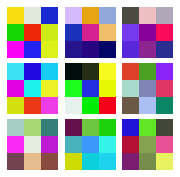

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

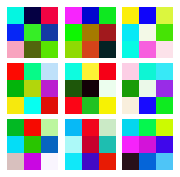

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

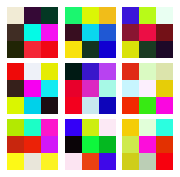

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

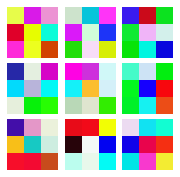

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

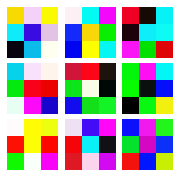

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

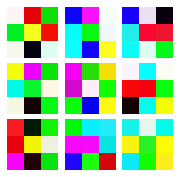

A sample to visualize weights.
 Here each element of 3x3 matrix represents the weights on each

kernel. The weights are color mapped, to understand better.


<Figure size 432x288 with 0 Axes>

In [17]:
i = 0
for m in model.modules():
  if isinstance(m, nn.Conv2d):
    if i == 0:
      plot_kernels(m.weight.data)
      print("A sample to visualize weights.\n Here each element of 3x3 matrix represents the weights on each\n")
      print("kernel. The weights are color mapped, to understand better.")
      plt.savefig('result.png')

### Output Plots

Text(0.5, 1.0, 'CIFAR10 Dataset: Accuracy vs Epochs')

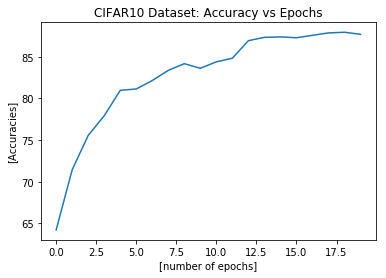

In [18]:
test_accuracies = [i*100 for i in test_accuracies]
# plot the training progress
plt.plot(range(0, len(test_accuracies)), test_accuracies)
plt.xlabel('[number of epochs]')
# plt.xlim([0, len(train_loss)])
plt.ylabel('[Accuracies]')
# plt.ylim([0.0, 1.0])
plt.title('CIFAR10 Dataset: Accuracy vs Epochs')

In [19]:
type(m.weight.data)

torch.Tensor

Text(0.5, 1.0, 'CIFAR 10 Dataset: Loss vs Epochs')

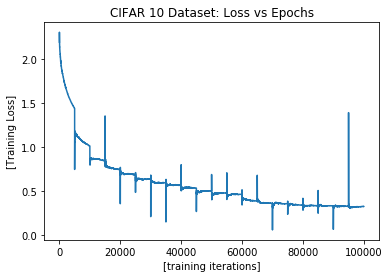

In [20]:
# test_accuracies = [i*100 for i in test_accuracies]
# plot the training progress
plt.plot(range(0, len(train_losses)), train_losses)
plt.xlabel('[training iterations]')
# plt.xlim([0, len(train_loss)])
plt.ylabel('[Training Loss]')
# plt.ylim([0.0, 1.0])
plt.title('CIFAR 10 Dataset: Loss vs Epochs')

The accuracy of this network comes out to be </t>    <font size = 4>   87.930 %</font>